# Class Activation Map (CAM)

This is one of many ways to visualize and get insights from a Convolutional Neural Network. What this basically does is that it creates a heatmap of "Class Activation" over the input image.  A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for every location in any input image, indicating how important each location is with respect to the class considered. Quite simply, it tells us which features the model is looking for. Keras will be the deep framing framework that is going to be utilized. I am starting to really love Keras, its just so easy to use and as an effect saves a lot of time coding. If tensorflow was used for this project it would have taken longer because tensorflow is not rich in helper functions. Everything that is needed for this are all in Keras.

There are a lot of interesting insights from the model that are shown towards the end of this exercise.

In [1]:
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import load_model
from skimage.transform import resize
import copy
%matplotlib inline
K.clear_session()

Using TensorFlow backend.
W0704 11:02:23.894480 140592764434240 deprecation_wrapper.py:119] From /localhome/prathmeshmadhu/.virtualenvs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0704 11:02:23.895087 140592764434240 deprecation_wrapper.py:119] From /localhome/prathmeshmadhu/.virtualenvs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0704 11:02:23.906845 140592764434240 deprecation_wrapper.py:119] From /localhome/prathmeshmadhu/.virtualenvs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



### For this exercise we will be using the VGG16 model

In [1596]:
# model = VGG16(weights='imagenet')
model_A_path = 'models/A_body_softmax_VGGFace_pretrained_resnet_E100_B32_I224_cvfold_1.model'
model_C_path = 'models/C_styled_softmax_VGGFace_pretrained_resnet_E100_B32_I224_cvfold_4.model'
# model_path = '/localhome/prathmeshmadhu/Desktop/incorrect_gradcam/VGGFace_E50_B32_I224_cvfold_4.model'
model_A = load_model(model_A_path)
model_C = load_model(model_C_path)

In [1783]:
model = model_A

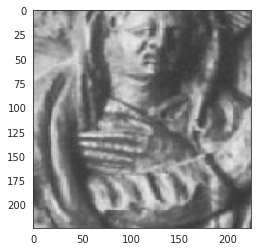

In [1784]:
### Sample Image

img_path = 'test/female/body_02664.jpg'
img=mpimg.imread(img_path)
plt.imshow(img)

### Resizing image to fit the input size of VGG

from keras.preprocessing import image
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

### Convert to numpy array

x = image.img_to_array(img)

### Reshape data so that it is in "batch" form because the model only accepts input in this form

import numpy as np
x = np.expand_dims(img, axis=0)

### "Batch" form

x.shape

### Preprocessing

from keras.applications.vgg16 import preprocess_input
x = preprocess_input(x)
x /= 255.0

### Prediction

(2048,)
Tensor("strided_slice_237:0", shape=(7, 7, 2048), dtype=float32)


array([-9.0617250e-06,  2.5369020e-06,  0.0000000e+00, ...,
        6.8557079e-06, -4.8384163e-07,  7.8600806e-06], dtype=float32)

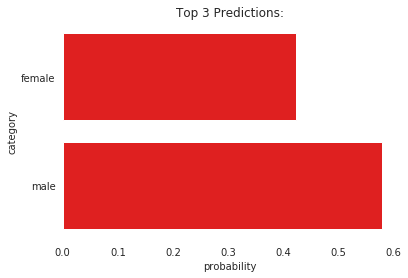

In [1785]:
classes = ['female','male']

import pandas as pd
preds = model.predict(x)[0]
# print (preds)
predictions = pd.DataFrame(columns=['category', 'probability'])
predictions['probability'] = preds
idx = np.argmax(preds)
label = classes[idx]

predictions['category'] = classes
predictions

# import pandas as pd
# from keras.applications.vgg16 import decode_predictions
# preds = model.predict(x)
# # print (preds)
# predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
# print('PREDICTION:',predictions.loc[0,'category'])
# predictions

import seaborn as sns
f = sns.barplot(x='probability',y='category',data=predictions,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

### Index of the prediction

argmax = np.argmax(preds[0])

### Get the index of the prediction

type(model.output)

output = model.output[:, argmax]
output

### We want to get the final Convolutional Layer

layers = model.layers
for layer in layers:
    if 'conv' in layer.name.lower():
        layer_to_use = layer.name.lower()
last_conv_layer = model.get_layer(layer_to_use)
last_conv_layer.name

### Get the Gradient

grads = K.gradients(output, last_conv_layer.output)[0]
grads.shape

### Each entry of this tensor is the mean intensity of the gradient over a specific feature map channel. This has a shape of (512,) and for custom it is (2048,)

pooled_grads = K.mean(grads, axis=(0, 1, 2))
print (pooled_grads.shape)

pooled_grads

print (last_conv_layer.output[0])

### Access the values of the quantities we just defined

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

### These are the values of these two quantities, as Numpy arrays, given our sample image of two elephants

pooled_grads_value, conv_layer_output_value = iterate([x])
pooled_grads_value

### We multiply each channel in the feature map array by "how important this channel is" with regard to the elephant class

for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# conv_layer_output_value[:,:,10]
pooled_grads_value

### Plotting the Heatmap

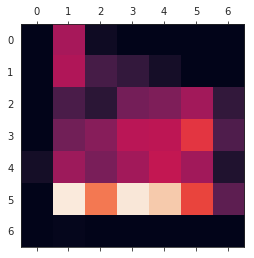

In [1786]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0.0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

### Load Image with CV2

In [1787]:
import cv2
img = cv2.imread(img_path)

### Resize the heatmap

In [1788]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

### Convert heatmap to RGB

In [1789]:
heatmap = np.uint8(255 * heatmap)

### Apply heatmap to original Image

In [1790]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

### Apply heatmap intensity factor

In [1791]:
hif = .9

In [1792]:
superimposed_img = heatmap * hif + img

### Save to disk

In [1793]:
output = 'output_images/'+img_path.split('/')[-1]
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

### Plot

Text(0.5, 1.0, 'male')

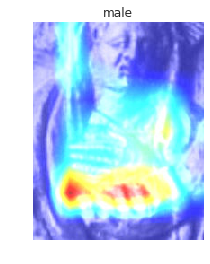

In [1794]:
# plt.figure(1)
# plt.imshow()

plt.figure(2)
plt.imshow(img)
plt.axis('off')
plt.title(label)

### Putting it all in a single funtion

In [183]:
def cam_pretrained(img_path, output_img_path):
    from keras.applications.vgg16 import VGG16
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    %matplotlib inline
    K.clear_session()
    
    model = VGG16(weights='imagenet')
    img=mpimg.imread(img_path)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, -2)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = output_img_path
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

In [184]:
import numpy as np
import pandas as pd

def cam_scratchtrained(img_path, output_img_path):
    from keras.applications.vgg16 import VGG16
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    %matplotlib inline
    K.clear_session()
    
    model = load_model('/localhome/prathmeshmadhu/Desktop/incorrect_gradcam/VGGFace_E50_B32_I224_cvfold_4.model')
    img=mpimg.imread(img_path)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 1, 1)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    classes = ['Gabriel/Man','Mary/Woman']
    preds = model.predict(x)[0]
    predictions = pd.DataFrame(columns=['category', 'probability'])
    predictions['probability'] = preds
    idx = np.argmax(preds)
    label = classes[idx]
    predictions['category'] = classes

    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]

    layers = model.layers
    for layer in layers:
        if 'conv' in layer.name.lower():
            layer_to_use = layer.name.lower()
    last_conv_layer = model.get_layer(layer_to_use)
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, -2)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = output_img_path
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.subplot(2, 1, 2)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

In [185]:
import numpy as np
import pandas as pd

def cam_scratchtrained_my(model, img_path, output_img_path):#, output_eps_path):
    
    model = load_model(model)
    img=mpimg.imread(img_path)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 1, 1)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    classes = ['female','male']
    preds = model.predict(x)[0]
    predictions = pd.DataFrame(columns=['category', 'probability'])
    predictions['probability'] = preds
    idx = np.argmax(preds)
    label = classes[idx]
    predictions['category'] = classes

    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]

    layers = model.layers
    for layer in layers:
        if 'conv' in layer.name.lower():
            layer_to_use = layer.name.lower()
    last_conv_layer = model.get_layer(layer_to_use)
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = output_img_path
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.subplot(2, 1, 2)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
#     plt.savefig(output_eps_path, type='eps', dpi=300)
    return None
    

### Trying it out on other images

/localhome/prathmeshmadhu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


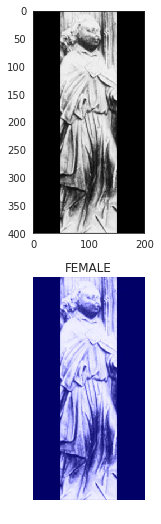

In [186]:
model_path = 'models/B_VGGFace_styled_pretrained_resnet_E100_B32_I224_cvfold_1.model'
img_path = 'test_images_gabriel/body_02507.jpg'
output_img_path = 'output_images/' + img_path.split('/')[-1]
cam_scratchtrained_my(model_path, img_path,output_img_path)